In [1]:
import numpy as np
import scipy.linalg

In [2]:
# Utilities:

def are_geq_0(t):
    """Check if all the elements of the array t are >= 0"""
    for elem in t:
        if elem < 0: return False
    return True

def is_well_defined(infinitesimal_generator):
    """Check if the infinitesimal generator is well defined, i.e. the rows sum up to zero."""
    threshold = 1e-10
    for transitions in infinitesimal_generator:
        if abs(sum(transitions)) > threshold:
            return False
    return True

def sample_discrete(N,p):
    """Computes N samples from discrete probability vector p"""
    n = len(p)
    S = np.cumsum(p)
    U = np.random.uniform(low=0.0, high=1.0, size=N)
    sampled_indexes = np.empty(N)
    for j in range(N):
        for i in range(n):
            if S[i] > U[j]:
                sampled_indexes[j] = i
                break
    if N == 1:
        return int(sampled_indexes[0])

    return sampled_indexes.astype(int)

# CTMC

A CTMC is a continuous-time stochastic process $\{X(t),t\ge 0\}$ defined on a finite state space with Markov property at each time $t\ge 0$. Finite-state CTMC spends an **exponentially distributed** amount of time in a given state before jumping out of it. Thus *exponential distributions* play an important role in CTMCs. 


## 1. Exponential distribution
Recall that for an exponential random variable $T\sim Exp(\lambda)$:
- $E[T] = \frac{1}{\lambda}$ and
- $Var[T] = \frac{1}{\lambda^2}$.

#### Exercise 1.1. Time to failure:

Suppose a new machine is put into operation at
time zero. Its lifetime is known to be an $Exp(\lambda)$ random variable with $\lambda = 0.1$ [1/hour].
What is the probability that the machine will give trouble-free service continuously for 1 day? Suppose the machine has not failed by the end of the first day. What is the probability that it will give trouble-free service for the whole of the next day?

What is the probability that the machine will give trouble-free service continuously for 1 day? 
<br>It is $$P(x > 24h) = 1 - P(x < 24h) = 1 - (1 - e^{-\lambda*24}) = 0.09$$
<br><br>
Suppose the machine has not failed by the end of the first day. What is the probability that it will give trouble-free service for the whole of the next day?
<br>Thanks to the memoryless property, it is $$P(x > 48h \ | \ x > 24h) = P(x > 24h \ + \ 24h \ | \ x > 24h) = P(x > 24h) = 0.09$$

### The minimum of independent exponential r.v.

Let $T_i$ be an $Exp(\lambda_i)$ random variable $(1\le i\le k)$, we can think of $T_i$ as the time when an event of type $i$ occurs and suppose $T_1, T_2,\dots , T_k$ are
independent. The r.v. $T = \min\{T_1, T_2,\dots , T_k\}$, representing the
time when the first of these k events occurs, is an exponential r.v. with $\lambda = \sum_{i=1}^k \lambda_i$.

#### Exercise 1.2. Hospital:

A hospital currently has
seven pregnant women waiting to give birth. Three of them are expected to
give birth to boys, and the remaining four are expected to give birth to girls.
From prior experience, the hospital staff knows that a mother spends on average 6 hours in the hospital before delivering a boy and 5 hours before delivering
a girl. Assume that these times are independent and exponentially distributed.
What is the probability that the first baby born is a boy and is born in the next
hour?

Let's define $K = argmin_k(T_k)$. We have that $P(K = k) = \frac{\lambda_k}{\lambda}$, $P(T < t) = \lambda e^{-\lambda t}$. Since K and T are independent, we have that $$P(K = k, T < t) = P(K = k)P(T < t)$$
<br>
<br>
If we set that $k \ = \ 0, \ 1, \ 2$ indicates the pregnant moms of a boy and $k \ = \ 3,\ 4,\ 5,\ 6$ are the pregnant moms of girls, we have that $E[T_k] = 6 \Rightarrow \lambda_k = \frac{1}{6}$ for $k \ = \ 0,\ 1,\ 2$, while we have $E[T_k] = 5 \Rightarrow \lambda_k = \frac{1}{5}$ for $k \ = \ 3, \ 4, \ 5, \ 6$. 
<br>
Moreover, we have that $\lambda = \frac{3}{6} + \frac{4}{5} = \frac{13}{10}$
<br><br>
What is the probability that the first baby born is a boy and is born in the next hour?
<br>
It is $$P((K \ = \ 0 \ or \ K \ = \ 1 \ or \ K \ = \ 2 \ ) \ and \ T \ < \ 1) = \frac{\sum_{k=0}^2\lambda_k}{\lambda} (1 - e^{-\lambda}) = \frac{3}{5}\frac{10}{13} (1 - e^{-\frac{13}{10}}) = 0.34$$

## 2. CTMC
Let $X(t)$ be the state of a system at time t. 

Random evolution of the system: suppose the system starts in state i. It stays there for an $Exp(q_i)$ amount of time, called the *sojourn time in state i*. At the end of the sojourn time in
state i, the system makes a sudden transition to state $j\ne i$ with probability $\pi_{i,j}$,
independent of how long the system has been in state i. In case state i is absorbing we set $q_i=0$.

Analogously to DTMCs, a CTMC can also be represented graphically by means
of a directed graph: the directed graph has one node for
each state. There is a directed arc from node i to node j if $\pi_{i,j} > 0$. The quantity
$q_{i,j}= q_i \pi_{i,j}$, called the transition rate from i to j, is written next to this arc. Note that there are no self-loops. Note that we can recover the original parameters $q_i$ and $\pi_{i,j}$ from the rates $q_{i,j}$:
$$q_i = \sum_{j}q_{i,j}$$
$$\pi_{i,j} = \frac{q_{i,j}}{q_i}.$$

In each state $i$, there's a race condition between $k$ edges, each exponentially distributed with rate $q_{ij}$, the exit rate is $q_{i,i} = -q_i$. The matrix $Q = (q_{ij})_{ij}$ is called **infinitesimal generator** of the CTMC.
Each row sum up to 0.

#### Exercise 2.1. CTMC class:

Define a class CTMC, with a method `__init__()` to initialize the infinitesimal generator

In [3]:
import numpy as np
class CTMC(object):
    '''Continuous-Time Markov Chain class'''

    def __init__(self, 
                 transition_rates):
        """Given a list of lists, where each i-th list represents the transition rates from state i to the other states,
        construct the infinitesimal generator of that list"""
        for element in transition_rates: # Check if all the transitions are >= 0
            assert are_geq_0(element)
        
        self.N = len(transition_rates)
        self.infinitesimal_generator = np.zeros((self.N, self.N))
        
        for i in range(self.N):
            self.infinitesimal_generator[i,:] = transition_rates[i]
            self.infinitesimal_generator[i,i] = -sum(transition_rates[i])

In [4]:
transition_rates = [[0,1,2],[3,0,1],[4,3,0]]
ctmc_mood = CTMC(transition_rates)

print("Is the constructed infinitesimal generator well-defined?", is_well_defined(ctmc_mood.infinitesimal_generator))
ctmc_mood.infinitesimal_generator

Is the constructed infinitesimal generator well-defined? True


array([[-3.,  1.,  2.],
       [ 3., -4.,  1.],
       [ 4.,  3., -7.]])

#### Exrcise 2.2.

Consider the SIR model and define a function `infinitesimal_generator_SIR()`that takes the rates $q_S, q_I, q_R$ as inputs and returns the infinitesimal generator `Q` after checking that it is well-defined.

##### Solution
We will consider that state 0 is the susceptible state, 1 is the infected state and 2 is the recovered state,

In [5]:
def infinitesimal_generator_SIR(rates):
    
    assert are_geq_0(rates)
    
    infinitesimal_generator = np.zeros((3,3))
    
    infinitesimal_generator[0,0] = -rates[1]
    infinitesimal_generator[0,1] = rates[1]
    
    infinitesimal_generator[1,1] = -rates[2]
    infinitesimal_generator[1,2] = rates[2]
    
    infinitesimal_generator[2,0] = rates[0]
    infinitesimal_generator[2,2] = -rates[0]
    
    assert is_well_defined(infinitesimal_generator)
    
    return infinitesimal_generator

In [6]:
rates = [0.01,10.,.5]
SIR = infinitesimal_generator_SIR(rates)
SIR

array([[-10.  ,  10.  ,   0.  ],
       [  0.  ,  -0.5 ,   0.5 ],
       [  0.01,   0.  ,  -0.01]])

### Jump chain and holding times

We can factorize a CTMC $X(t)$ in a DTMC $Y_n$ called **jump chain**, with probability matrix $\Pi$ where $\pi_{i,j}=\frac{q_{i,j}}{-q_{i,i}}$ if $i\ne j$ and $\pi_{ii}=0$ .

#### Exercise 2.3. Infinitesimal generator:

Define a function `jump_chain_matrix()` which takes the infinitesimal generator `Q` as input and returns the transition matrix $\Pi$.

In [7]:
def jump_chain_matrix(Q):
    
    N = len(Q)
    J = np.zeros((N,N))
    
    for i in range(N):
        for j in range(N):
                J[i,j] = Q[i,j] / (-Q[i,i]) if Q[i,i] != 0 else 0
                J[i,i] = 0
        
    return J

In [8]:
jump_chain_matrix(ctmc_mood.infinitesimal_generator)

array([[0.        , 0.33333333, 0.66666667],
       [0.75      , 0.        , 0.25      ],
       [0.57142857, 0.42857143, 0.        ]])

#### Exercise 2.4. Plot continuous trajectory:

Recall the Kolmogorov equation and define a function `continuous_trajectories()` taking as input $Q$, the initial distribution $p_0$ and a time $t$. Use a solver for differential equations and return the solution. 

Consider one of the models define before and plot the trajectory of each state against time.

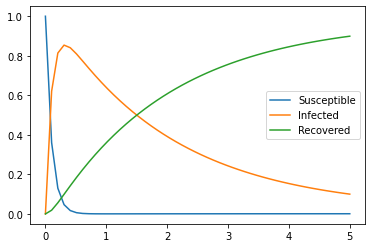

In [9]:
from scipy.integrate import odeint
import matplotlib.pyplot as plt
def continuous_trajectories(Q,p0,t):
    
    def forward_kolmogorov(p,t):
        return np.matmul(p,Q)
    
    p_t = odeint(forward_kolmogorov, p0, t)

    return p_t

p0 = np.array([1.,0,0])
t = np.linspace(0,5)

infinitesimal_generator_SIR(rates)
p_t = continuous_trajectories(SIR, p0, t)
plt.plot(t,p_t[:,0], label="Susceptible")
plt.plot(t,p_t[:,1], label="Infected")
plt.plot(t,p_t[:,2], label="Recovered")
plt.legend()

#### Exercise 2.5. Plot stochastic trajectory:

Use the jump chain matrix to generate stochastic trajectories of the CTMC (as already seen in DTMC). However, the time intervals are non-constant: compute the holding times using the respective exit rates. Plot such stochastic trajectories with respect to time.

In [10]:
def simulation_CTMC(Q,p0,n_iter):

    J = jump_chain_matrix(Q)
    
    state = sample_discrete(N = 1, p = p0)
    trajectory = [state]
    times = [0]
    
    if n_iter == 0:
        return (trajectory,time) 
    
    for iter in range(n_iter):
        previous_state = int(trajectory[-1])
        beta = 1. / -Q[previous_state, previous_state]
        delta_t = np.random.exponential(beta)
        times.append(round(times[-1] + delta_t,5))
        state = sample_discrete(N = 1, p = J[state,:])
        trajectory.append(state)
        
    return (trajectory, times) 

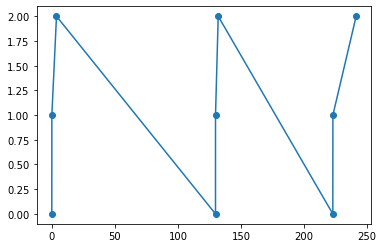

[ 0 ] 	 Susceptible
[ 0.04896 ] 	 Infected
[ 3.72398 ] 	 Recovered
[ 129.74976 ] 	 Susceptible
[ 129.76147 ] 	 Infected
[ 131.89796 ] 	 Recovered
[ 222.72405 ] 	 Susceptible
[ 222.78946 ] 	 Infected
[ 241.22558 ] 	 Recovered


In [11]:
rates = [0.01,10.,.1]
SIR = infinitesimal_generator_SIR(rates)

result = simulation_CTMC(SIR, p0, 8)
plt.plot(result[1], result[0], 'o-')
plt.show()
dic = {0 : "Susceptible", 1 : "Infected", 2 : "Recovered"}
for i in range(len(result[0])):
    print("[",result[1][i],"] \t", dic[result[0][i]])

## 3. Poisson Process 

Consider systems whose state transitions are triggered by streams of
events that occur one at a time and assume that the successive inter-event
times are iid exponential random variables.
$N_{\lambda}(0,t)$ is a process that counts how many times an exponential distribution with rate $\lambda$ has fired from time $0$ to time $t$. It can be seen as a CTMC with state space $S=\mathbb{N}$ and $Q$ is: $q_{i,i+1}=\lambda$ and zero elsewhere. The time $t_i = t_{i-1}+D_i$, with $D_i\sim Exp(\lambda)$.

#### Exercise 3.1. Repairing machines:

A machine shop consists of N machines
and M repair people ($M\le N$). The machines are identical, and the lifetimes
of the machines are independent $Exp(\mu)$ random variables. When the machines fail,
they are serviced in the order of failure by the M repair persons. Each failed machine
needs one and only one repair person, and the repair times are independent $Exp(\lambda)$
random variables. A repaired machine behaves like a new machine. Let $X(t)$ be the
number of machines that are functioning at time t.

Draw the diagram for $N = 4$ and $M = 2$ and define a function that takes $N, M, \lambda$ and $\mu$ as input and return the infitesimal generator.

<img src="imgs/machine_shop.png" width="600">

In [12]:
def machine_shop(N, M, repair, lifetime):
    Q = np.zeros((N+1,N+1))
    Q[0,1] = M * repair
    Q[0,0] = -Q[0,1]
    
    for state in range(1,N):
        Q[state,state - 1] = state * lifetime
        Q[state,state + 1] = M * repair if state <= N - M else (N - state) * repair
        Q[state,state] = -Q[state, state - 1] -Q[state,state+1]
    
    Q[N,N-1] = N * lifetime
    Q[N,N] = -Q[N,N-1]
        
    return Q 

In [13]:
machine = machine_shop(4,2,3,2)
print("Is the infinitesimal generator well-defined? ", is_well_defined(machine))
machine

Is the infinitesimal generator well-defined?  True


array([[ -6.,   6.,   0.,   0.,   0.],
       [  2.,  -8.,   6.,   0.,   0.],
       [  0.,   4., -10.,   6.,   0.],
       [  0.,   0.,   6.,  -9.,   3.],
       [  0.,   0.,   0.,   8.,  -8.]])

#### Exercise 3.2. Engines of a jet airplane:

Draw the diagram for a commercial jet airplane that has four engines, two on each wing. Each engine lasts for a random amount of time that is an exponential random variable with parameter $\lambda$ and then fails. If the failure takes place in
flight, there can be no repair. The airplane needs at least one engine on each wing to
function properly in order to fly safely. Model this system so that we can predict the
probability of a trouble-free flight.

<img src="imgs/jet_engine.png" width="600">

Probability of having a trobule-free flight of 4 hours: 0.993940512173951


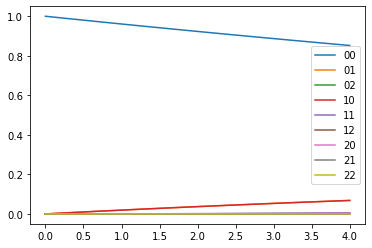

In [33]:
def airplane(lifetime):
    
    rate = 1. / lifetime
    Q = np.zeros((9,9))
    
    # State 00
    Q[0,1] = rate # to 01
    Q[0,3] = rate # to 10
    Q[0,0] = -2*rate
    ######################
    # State 01
    Q[1,2] = rate # to 02
    Q[1,4] = rate # to 11
    Q[1,1] = -2*rate
    ######################
    # State 02
    Q[2,5] = rate # to 12
    Q[2,2] = -rate
    ######################
    # State 10
    Q[3,4] = rate # to 11
    Q[3,6] = rate # to 20
    Q[3,3] = -2*rate
    ######################
    # State 11
    Q[4,5] = rate # to 12
    Q[4,7] = rate # to 21
    Q[4,4] = -2*rate
    ######################
    # State 12
    Q[5,8] = rate # to 22
    Q[5,5] = -rate
    ######################
    # State 20
    Q[6,7] = rate # to 21
    Q[6,6] = -rate
    ######################
    # State 21
    Q[7,8] = rate # to 22
    Q[7,7] = -rate
    ######################
    
    return Q

jet = airplane(50)
p0 = [1,0,0,0,0,0,0,0,0]
t = np.linspace(0,4)
p_t = continuous_trajectories(jet, p0, t)
[plt.plot(t,p_t[:,i], label=("0"+np.base_repr(i,base=3))[-2:]) for i in range(9)]
plt.legend()

print("Probability of having a trobule-free flight of 4 hours:", sum(p_t[-1,[0,1,3,4]]))

#### Exercise 3.3. Gas station:
A gas station has a single pump and no space for vehicles to wait (if a vehicle arrives and the pump is not available, it leaves). Vehicles arrive to the gas station following a Poisson process with a rate of $\lambda=\frac{3}{20}$ vehicles per minute, of which $75\%$ are cars and $25\%$ are motorcycles. The refuelling time can be modelled with an exponential random variable with mean 8 minutes for cars and 3 minutes for motorcycles, that is, the services rates are $\mu_c=\frac{1}{8}$ cars and $\mu_m=\frac{1}{3}$ motorcycles per minute respectively. Describe this problem as a continuous-time Markov chain, i.e., draw the diagram and define the infinitesimal generator.

<img src="imgs/gas.png" width="250">

In [34]:
def gas_station(arrival_rate, p_car, refill_car, refill_mcycle):
    
    Q = np.zeros((3,3))
    
    Q[0,1] = p_car * arrival_rate
    Q[0,2] = (1-p_car) * arrival_rate
    Q[0,0] = -Q[0,1] -Q[0,2]
    
    Q[1,0] = refill_car
    Q[1,1] = -Q[1,0]
    
    Q[2,0] = refill_mcycle
    Q[2,2] = -Q[2,0]
    
    return Q

gas_station(3/20, 0.75, 1/8, 1/3)

array([[-0.15      ,  0.1125    ,  0.0375    ],
       [ 0.125     , -0.125     ,  0.        ],
       [ 0.33333333,  0.        , -0.33333333]])

## 4. Birth-death process and queues

General class of CTMC on $S = \mathbb{N}$ with birth rate $\lambda_i$ (from $i$ to $i+1$) and death rate $\mu_i$ (from $i$ to $i-1$). When a birth occurs, the process goes from state $i$ to $i + 1$. When a death occurs, the process goes from state $i$ to state $i − 1$.

The birth–death process is the most fundamental example of a **queueing model**. This is a queue with Poisson arrivals, drawn from an infinite population, and $C$ servers with exponentially distributed service time with $K$ places in the queue. 

#### Exercise 4.1. BirthDeath class:

Define a general `BirthDeath` class inheriting from the class CTMC in order to initialize the number of states, the rates of forward and backward transitions.

In [ ]:
class BirthDeath(CTMC):
    ''' Birth-Death Process '''

    def __init__(
            self,
            # complete
    ):

        
    # CODE HERE


#### Exercise 4.2. Telefone switch:

A telephone switch can handle K calls at any
one time. Calls arrive according to a Poisson process with rate $\lambda$. If the switch is
already serving K calls when a new call arrives, then the new call is lost. If a call
is accepted, it lasts for an $Exp(\mu)$ amount of time and then terminates. All call
durations are independent of each other. Let $X(t)$ be the number of calls that are
being handled by the switch at time t. Model $X(t)$ as a CTMC.

What if the caller can put a maximum of H callers on hold?